In [388]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [389]:
pos_step = 1.0
x_range = np.arange(0,10,pos_step)
y_range = np.arange(0,10,pos_step)

In [390]:
vmin = 1.0
vmax = 1.5
spd_range = np.linspace(vmin,vmax,5)
print(spd_range)

[1.    1.125 1.25  1.375 1.5  ]


In [391]:
num_angles = 8
hdg_range = np.arange(0,2*np.pi,2*np.pi/num_angles)
print(hdg_range)

[0.         0.78539816 1.57079633 2.35619449 3.14159265 3.92699082
 4.71238898 5.49778714]


In [392]:
grid_points = [(x,y,spd*np.cos(theta),spd*np.sin(theta)) for x in x_range for y in y_range for theta in hdg_range for spd in spd_range]
num_points = len(grid_points)
print(num_points)

4000


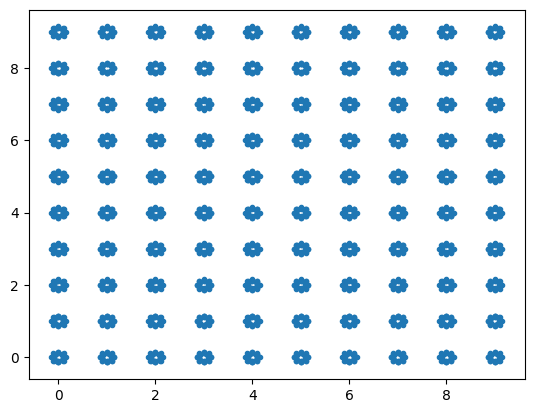

In [393]:
vel_scale = 0.1
plt.plot([p[0]+vel_scale*p[2] for p in grid_points],[p[1]+vel_scale*p[3] for p in grid_points],'.')

In [394]:
cost_matrix = np.inf*np.ones((num_points,num_points))

In [395]:
dmax = 1.5*pos_step
amax = 0.5*(vmax-vmin)

def travel_time(s1,s2):
    x1,y1,vx1,vy1 = s1
    x2,y2,vx2,vy2 = s2
    if x1==x2 and y1==y2:
        return np.inf
    dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    if dist>dmax:
        return np.inf
    spd = np.sqrt(vx1**2 + vy1**2)
    t_guess = dist/spd
    dx = (x2 - x1 - 0.5*(vx1+vx2)*t_guess)
    dy = (y2 - y1 - 0.5*(vy1+vy2)*t_guess)
    if dx**2 + dy**2 > dmax**2:
        return np.inf
    ax = (vx2-vx1)/t_guess
    ay = (vy2-vy1)/t_guess
    if ax**2 + ay**2 > amax**2:
        return np.inf
    return t_guess
    

In [396]:
for (i1,s1) in enumerate(grid_points):
    for (i2,s2) in enumerate(grid_points):
        t12 = travel_time(s1,s2)
        cost_matrix[i1,i2] = t12

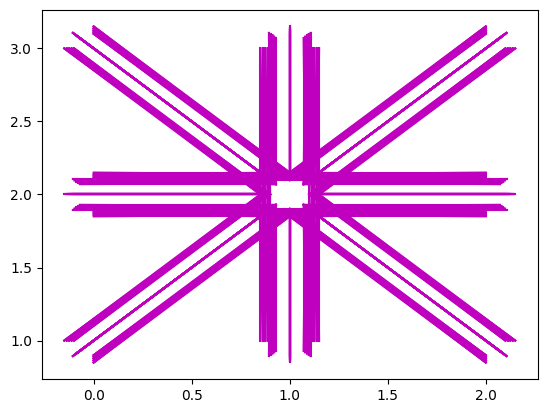

In [397]:
for (i1,s1) in enumerate(grid_points):
    if s1[0]!=1.0:
        continue
    if s1[1]!=2.0:
        continue
    for (i2,s2) in enumerate(grid_points):
        if cost_matrix[i1,i2] != np.inf:
            plt.plot([s1[0]+vel_scale*s1[2],s2[0]+vel_scale*s2[2]],
                     [s1[1]+vel_scale*s1[3],s2[1]+vel_scale*s2[3]],'m-')
plt.show()

In [398]:
from scipy.sparse.csgraph import shortest_path
distance,predecessors = shortest_path(cost_matrix, return_predecessors=True)

In [401]:
curr_node = 130
target_node = 3490
print(grid_points[curr_node])
print(grid_points[target_node])
print(min(distance[curr_node,:]))
print(distance[curr_node,target_node])

(0.0, 3.0, 6.123233995736766e-17, 1.0)
(8.0, 7.0, 6.123233995736766e-17, 1.0)
0.0
7.347037031024838


3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052
3052


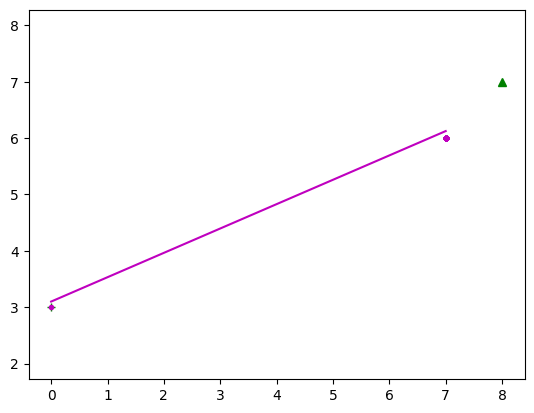

In [402]:
plt.plot([grid_points[curr_node][0]],
         [grid_points[curr_node][1]],'g+')
plt.plot([grid_points[target_node][0]],
         [grid_points[target_node][1]],'g^')
for kk in range(len(grid_points)):
    next_node = predecessors[curr_node,target_node]
    print(next_node)
    plt.plot([grid_points[curr_node][0] + vel_scale*grid_points[curr_node][2],
              grid_points[next_node][0] + vel_scale*grid_points[next_node][2]],
             [grid_points[curr_node][1] + vel_scale*grid_points[curr_node][3],
              grid_points[next_node][1] + vel_scale*grid_points[next_node][3]],'m-')
    plt.plot([grid_points[curr_node][0],
              grid_points[next_node][0]],
             [grid_points[curr_node][1],
              grid_points[next_node][1]],'m.')
    curr_node=next_node
    if curr_node==target_node:
        break
plt.axis('equal')
plt.show()